In [1]:
import numpy as np 
from operator import itemgetter
import math
import networkx as nx
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.stats import expon
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd 
import math




In [2]:
def bootstrap_ratio_and_se(X, Y, B):
    n = len(X)  # Assume X and Y have the same length
    bootstrap_fractions = []

    for _ in range(B):
        bootstrap_X = np.random.choice(X, size=n, replace=True)
        bootstrap_Y = np.random.choice(Y, size=n, replace=True)
        bootstrap_diff = bootstrap_X - bootstrap_Y
        fraction_leq_0 = np.sum(bootstrap_diff > 0) / n
        bootstrap_fractions.append(fraction_leq_0)

    bootstrap_fractions = np.array(bootstrap_fractions)
    mean_fraction = np.mean(bootstrap_fractions)
    ci_lower = np.percentile(bootstrap_fractions, 2.5)
    ci_upper = np.percentile(bootstrap_fractions, 97.5)
    
    return mean_fraction, ci_lower,ci_upper

In [3]:
from collections import defaultdict

def analyze_topic_visits(W_person_topics, topic_name_X, user_list):
    W1 = defaultdict(int)  
    W2 = defaultdict(int) 
    X = defaultdict(list)
    Y = defaultdict(list)

    for person in user_list: 
        try:
            visits=W_person_topics[person]
        except: 
            continue
        visited_topics = {}
        
        for visit in visits:
            website, time_visited = visit
            if website not in visited_topics:
                visited_topics[website] = time_visited
            else:
                visited_topics[website] = min(visited_topics[website], time_visited)

        time_X = visited_topics[topic_name_X]


        for other_topic, other_time in visited_topics.items():
            if other_topic == topic_name_X:
                continue
            
            X[other_topic].append(other_time)
            Y[other_topic].append(time_X)
            W1[other_topic] += 1
            if  other_time>time_X:  
                W2[other_topic] += 1
            else: 
                W2[other_topic]+=0

    return dict(W1), dict(W2), X,Y


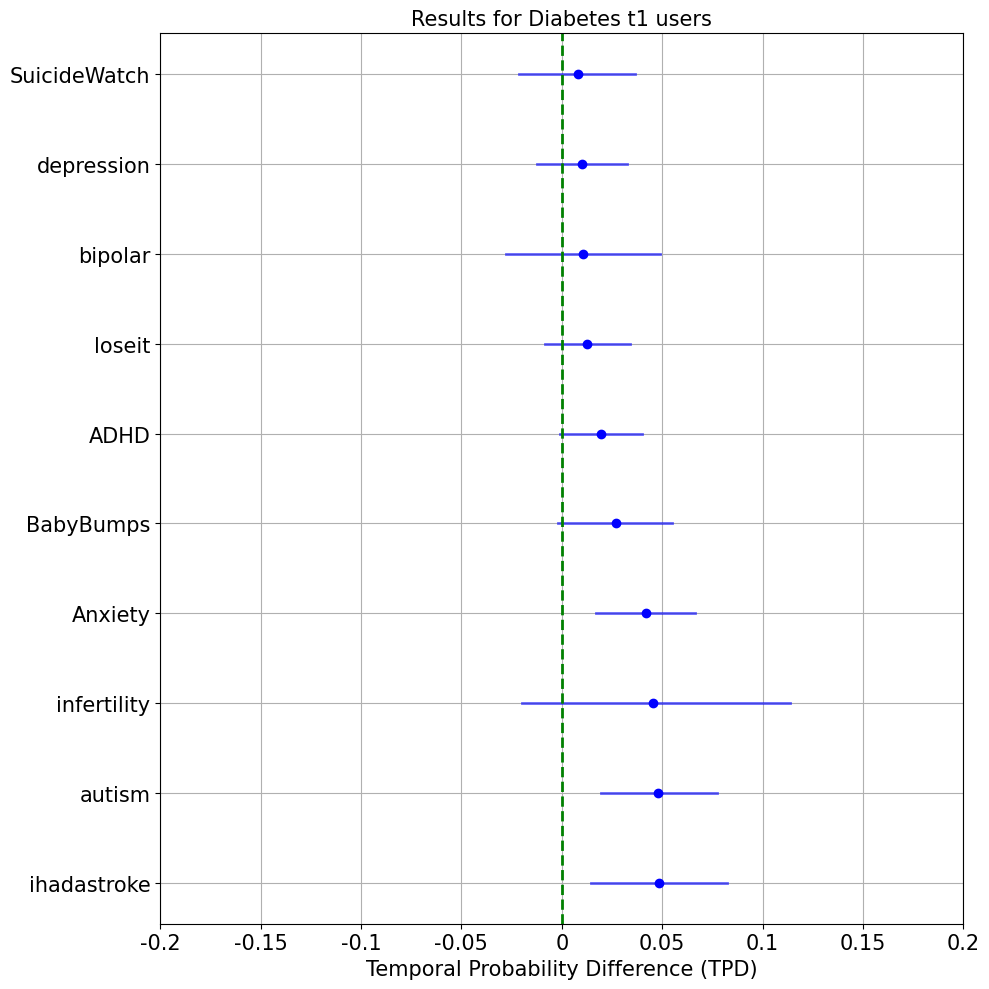

In [13]:

# User_t1: a list of users who visited diabetes-t1 reddit.
# User_t2: a list of users who visited diabetes-t2 reddit.
## W_person_topics is a dictionary, personID is the key, the value is a list of the reddits the user has visited.

topic_name_X ='diabetes'
W1, W2,X,Y = analyze_topic_visits(W_person_topics, topic_name_X,User_t1)

D1 =W1
D2 =W2


ratio={}
confidence_intervals={}
for topic,value in X.items():
    if topic not in W_disease: 
        continue

    ratio2, se1,se2= bootstrap_ratio_and_se(X[topic], Y[topic], 10000)
    r= D2[topic] / D1[topic]
    ratio[topic]=r-ratio2
    confidence_intervals[topic]=(r-se1,r-se2)
    

# Sort topics based on ratio
sorted_topics = sorted(ratio, key=ratio.get)#, reverse=True)


# Step 4: Plot the top 10 topics, 
top_10_topics = sorted_topics[:10]
X=[]
fig, ax = plt.subplots(figsize=(10, 10))

ii=0
for i, topic in enumerate(top_10_topics):
    p = ratio[topic]
    ci_lower, ci_upper = confidence_intervals[topic]
    
    if ci_lower>0:    
        ax.plot([ci_lower, ci_upper], [ii, ii], color='blue', lw=2, alpha=0.6)
        ax.scatter([p], [ii], color='blue', zorder=5)
    elif ci_upper<0:
        ax.plot([ci_lower, ci_upper], [ii, ii], color='red', lw=2, alpha=0.6)
        ax.scatter([p], [ii], color='red', zorder=5)
    else: 
        continue
        
    X.append(topic)
    ii+=1
    

ax.invert_yaxis()
ax.axvline(x=0, color='green', linestyle='--', lw=2)
ax.set_yticks(range(len(X)))
ax.set_yticklabels(X, fontsize=15) 
ax.set_xticklabels([-0.2,-0.15, -0.1,-0.05, 0,0.05,0.1,0.15,0.2], fontsize=15) 
ax.set_xlabel("Temporal Probability Difference (TPD)", fontsize=15)
ax.set_title("Results for Diabetes t1 users", fontsize=15)
ax.grid(True)
plt.xlim([-0.2,0.2])
plt.tight_layout()
plt.show()



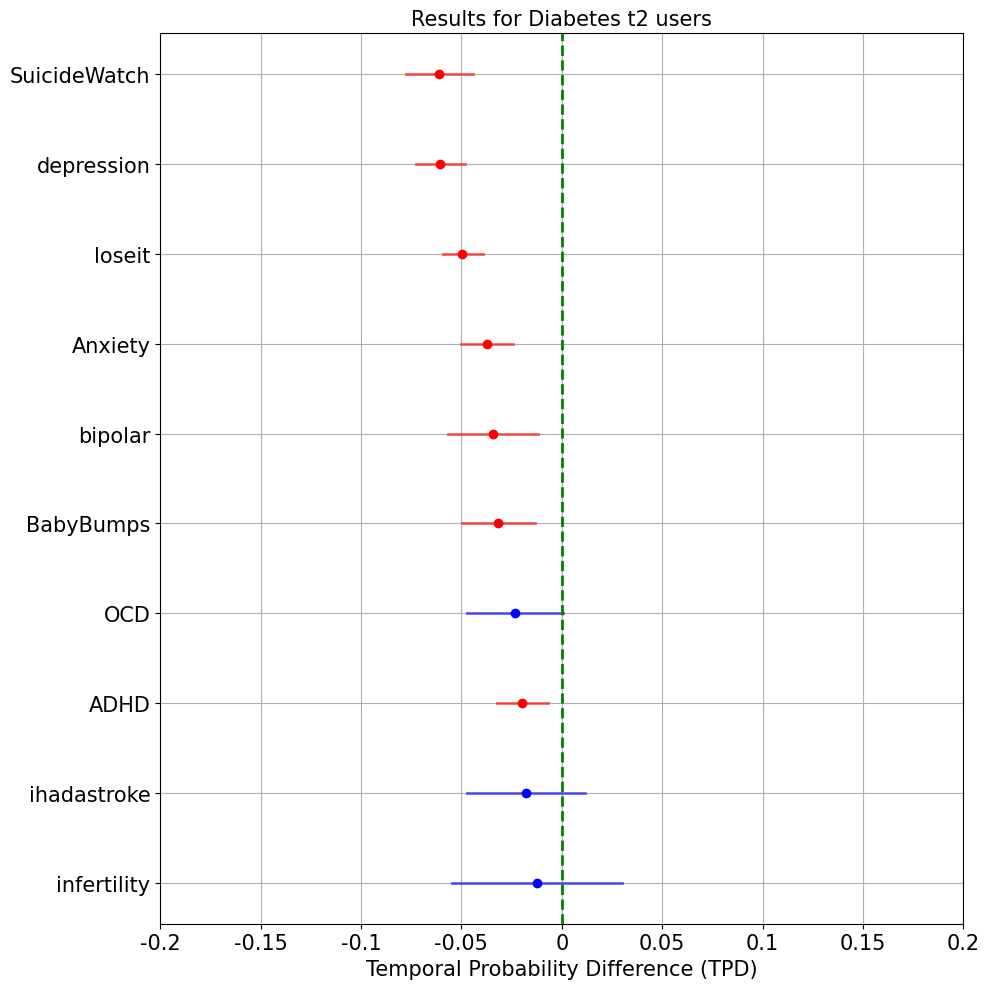

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


topic_name_X ='diabetes'
W1, W2,X,Y = analyze_topic_visits(W_person_topics, topic_name_X,User_t2)

D1 =W1
D2 =W2


#ratio = {topic: D2[topic] / D1[topic] for topic in D1 if topic in D2}
ratio={}
confidence_intervals={}
for topic,value in X.items():
    if topic not in W_disease: 
        continue
    #print (len(X[topic]), len(Y[topic]))
    
    #bootstrap_ratio_and_se(X, Y, B):
    ratio2, se1,se2= bootstrap_ratio_and_se(X[topic], Y[topic], 10000)
    #try:
    r= D2[topic] / D1[topic]
    #except: 
    #r= -ratio2
    ratio[topic]=r-ratio2
    confidence_intervals[topic]=(r-se1,r-se2)
    

# Step 2: Sort topics based on ratio
sorted_topics = sorted(ratio, key=ratio.get)#, reverse=True)


# Step 4: Plot the top 30 topics, starting with the largest at the top
top_30_topics = sorted_topics[:10]
X=[]
fig, ax = plt.subplots(figsize=(10, 10))

ii=0
for i, topic in enumerate(top_30_topics):
    p = ratio[topic]
    ci_lower, ci_upper = confidence_intervals[topic]

    # Plot a horizontal line for each topic
    
    if ci_lower>0:    
        ax.plot([ci_lower, ci_upper], [ii, ii], color='blue', lw=2, alpha=0.6)
        ax.scatter([p], [ii], color='blue', zorder=5)
    elif ci_upper<0:
        ax.plot([ci_lower, ci_upper], [ii, ii], color='red', lw=2, alpha=0.6)
        ax.scatter([p], [ii], color='red', zorder=5)
    else: 
        continue
        
    X.append(topic)
    ii+=1
    
    
    
    

# Reverse the y-axis order to have the largest value at the top
ax.invert_yaxis()

ax.axvline(x=0, color='green', linestyle='--', lw=2)
# Labeling



# ax.set_yticks(range(len(X)))
# ax.set_yticklabels(X)#top_30_topics)
# ax.set_xlabel("Temporal Probability Difference (TPD)")
# ax.set_title("Results for Diabetes_t1 users")
# ax.grid(True)
# plt.xlim([-0.5,0.5])



#ax.set_xticklabels(ax.get_xticks(), fontsize=12) 
#ax.set_xticks([-0.2,-0.1,0,0.1,0.2],fontsize=30)
ax.set_yticks(range(len(X)))
#ax.set_yticklabels(X)#top_30_topics)

#ax.set_xticklabels(ax.get_xticks(), fontsize=12) 
ax.set_yticklabels(X, fontsize=15) 
ax.set_xticklabels([-0.2,-0.15, -0.1,-0.05, 0,0.05,0.1,0.15,0.2], fontsize=15) 
#ax.set_yticklabels(X)#top_30_topics) 

ax.set_xlabel("Temporal Probability Difference (TPD)", fontsize=15)
ax.set_title("Results for Diabetes t2 users", fontsize=15)
ax.grid(True)
plt.xlim([-0.2,0.2])

# Show the plot
plt.tight_layout()
plt.show()

